In [426]:
import csv
import random
import math
import numpy as np 
import operator
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.spatial import distance
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score, precision_score,recall_score
from collections import defaultdict
from sklearn.mixture import GaussianMixture 
from sklearn.cluster import AgglomerativeClustering
from numpy import linalg as LA
from sklearn import metrics

import matplotlib.pyplot as plt
from matplotlib import style
import re
import seaborn as sns
from scipy import optimize as op
%matplotlib inline

In [271]:
def split_dataset(data,val):
    X = data.loc[1:, data.columns != val]
    Y = data.loc[1:, val]
    X_train, X_test, Y_train, Y_test = train_test_split(  X, Y, test_size = 0.25,shuffle=True)
    return X, Y, X_train, X_test, Y_train, Y_test

In [215]:
class KNN():
    def predict(self, inputs, k):
        predictions = []
        for i in range(len(inputs)):
            row = inputs[i]
            label = self.closest(row,k)
            predictions.append(label)
        return predictions

    def fit(self, X_train, Y_train):
        self.Y_train = Y_train
        self.X_train = X_train
    
    def euclid_dist(self, x, y):
        return distance.euclidean(x,y)
    
    def manhattan_dist(self, x, y):
        return distance.cityblock(x,y)
    
    def cosine_dist(self, x, y):
        return distance.cosine(x,y)
    

    def closest(self, row, k):
        dists = []
        l1 = len(self.X_train)
        for i in range(l1):
            dists.append((i,self.euclid_dist(self.X_train[i],row)))
        k_labels = []
        dists = sorted(dists, key=lambda x:x[1])[0:k]
        for i in range(k):
            val = self.Y_train[dists[i][0]]
            k_labels.append(val)
        c = Counter(k_labels)
        return c.most_common()[0][0]

# Question 1

## Part 1

In [487]:
def data_standardize(X):
    mean, std = [], []
    l1 = len(X[0])
    for i in range(l1):
        std.append(np.std(X[:, i]))
        mean.append(np.mean(X[:, i]))
    mean_new = []
    for row in X:
        l1 = len(row)
        for i in range(l1):
            diff = row[i]-mean[i]
            row[i] = float(float(diff)/float(std[i]))
    for i in range(l1):
        X_mean = np.mean(X[:, i])
        mean_new.append(X_mean)
    return X, mean_new

In [488]:
def pca(X):
    Xstd, mean_new = data_standardize(X)
    Xstd = Xstd - mean_new
    tmp = Xstd.T.astype(float)
    Xv = np.cov(tmp)
    val, vec = LA.eig(Xv)
    l1 = len(val)
    ts, s, arr, d = sum(val), 0.0, [], 0
    for i in range(l1):
        s += val[i]
        arr.append(vec[i])
        var = s/float(ts)
        if var > 0.9:
            break
    arr = np.transpose(arr)
    Xfinal = np.dot(Xstd, arr)
    return Xfinal

In [489]:
data = pd.read_csv('q1.csv', ',')

data = data.loc[1:, :]

X = data.values[:, :-1]
Y = data.values[:, -1]

X = X.astype(float)
Xfinal = pca(X)
print(Xfinal.shape)

(24997, 14)


In [490]:
def purity_score(y_true, y_pred):
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    c1 = np.amax(contingency_matrix, axis=0)
    return np.sum(c1) / np.sum(contingency_matrix)

## Part 2

In [491]:
def kmeans(Xfinal, k = 5, max_iter = 10):
    centroids = {}
    for i in range(k):
        centroids[i] = Xfinal[i][:-1]
    o_cls = {}
    for i in range(max_iter):
        n_classifications = {}
        for i in range(k):
            n_classifications[i] = []
        
        for row in Xfinal:
            dist = [np.linalg.norm(row[:-1] - centroids[i]) for i in centroids]
            _class = dist.index(min(dist))
            n_classifications[_class].append(row)
        
        prev = dict(centroids)
        
        for cls in n_classifications:
            tt = n_classifications[cls]
            tt = np.asarray(tt)
            centroids[cls] = np.average(tt[:, :-1], axis=0)
        o_cls = n_classifications
        
    return centroids, o_cls

In [492]:
def predict_kmeans(centroids, row):
    dist = [np.linalg.norm(row - centroids[i]) for i in centroids]
    classification = dist.index(min(dist))
    return classification

In [493]:
def kmeansClustering(X_train, X_test, Y_train, Y_test):
    dataset = np.column_stack([X_train, Y_train])
    test = np.column_stack([X_test, Y_test])
    dataset[:, :-1] = dataset[:, :-1].astype(float)
    centroids, classifications = kmeans(dataset)
    
    Y_pred = []

    correct = 0

    for i in range(len(X_test)):
        cls = predict_kmeans(centroids, X_test[i])
        outcomes = [tmp[-1] for tmp in classifications[cls]]
        tt = max(set(outcomes), key=outcomes.count)
        Y_pred.append(tt)
        if tt == Y_test[i]:
            correct += 1
    
    
    score = purity_score(Y_test, Y_pred)
    
    print("Purity of Clusters using K Means")
    print(score)

In [494]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25,shuffle=True)
kmeansClustering(X_train, X_test, Y_train, Y_test)

Purity of Clusters using K Means
0.84352


## Part 3

In [497]:
def GMM(X_train, X_test, Y_train, Y_test):
    gmm = GaussianMixture(n_components = 5)

    gmm.fit(X_train)

    Y_pred = gmm.predict(X_test)
    score = purity_score(Y_test, Y_pred)
    
    print("Purity of clusters using GMM: ")
    print(score)

In [498]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25,shuffle=True)
GMM(X_train, X_test, Y_train, Y_test)

Purity of clusters using GMM: 
0.79248


## Part 4

In [495]:
def HierarchicalClustering(dataset, labeled_arr):
    purity = []
    H_Model = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='single')
    out = H_Model.fit_predict(dataset)
    unique_out = set(out)
    for outs in unique_out:
        check_arr = []
        for j in range(len(dataset)):
            if out[j] == outs:
                check_arr.append(labeled_arr[j])
        unique_arr = set(check_arr)
        max_count = 0
        for label in unique_arr:
            max_count = max(max_count, check_arr.count(label))
        purity.append(float(max_count)/float(len(check_arr)))
    print(purity)

In [496]:
HierarchicalClustering(Xfinal, Y)

[1.0, 0.5344565391387867, 1.0, 1.0, 1.0]


## Part 5

Technically PCA can be used on categorical data but it won’t yield proper results. 
PCA is designed for continuous variables.
It tries to minimize variance but the concept of variance breaks down when you have categorical data.

# Question 2

In [404]:
df = pd.read_csv('AdmissionDataset/data.csv')
df = df.apply(np.random.permutation)
df.rename(columns=lambda x: x.strip(), inplace=True)
df.drop(columns={'Serial No.'}, inplace=True)
df.corr()['Chance of Admit'].round(1)
df.drop(columns={'LOR', 'Research'}, inplace=True)
df['Chance of Admit'].median()
targets = np.where(df['Chance of Admit'] >= 0.5, 1, 0)
targets.shape
df['Probability of Acceptance'] = targets
df.head()
targets.sum()/len(targets)
df = df.drop(['Chance of Admit'], axis=1)
df.head()
inputs = df.iloc[:, :-1]

In [405]:
X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size = 0.25,shuffle = True, random_state = 20 )
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)
classifier = KNN()
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test, 3)
print("Accuracy using KNN:", accuracy_score(y_test, predictions)*100, "%")

Accuracy using KNN: 85.84070796460178 %


In [406]:
class RegularizedLogisticRegression:
    def __init__(self, lr=0.01, num_iter=100000, fit_intercept=True, verbose=False,reg=10):
        self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept
        self.reg = reg
    
    def __add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
    
    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    def __loss(self, h, y):
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
    
    def fit(self, X, y):
        if self.fit_intercept:
            X = self.__add_intercept(X)
        
        # weights initialization
        self.theta = np.zeros(X.shape[1])
        
        for i in range(self.num_iter):
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            gradient = np.dot(X.T, (h - y)) / y.size
            self.theta -= self.lr * (gradient + self.reg*self.theta/y.size)
            
        
    def predict_prob(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)
    
        return self.__sigmoid(np.dot(X, self.theta))
    
    def predict(self, X, threshold):
        return self.predict_prob(X) >= threshold

In [407]:
model = RegularizedLogisticRegression(lr=0.001, num_iter=10000,reg=100)
model.fit(X_train,y_train)
preds = model.predict(X_test,0.5)
(preds == y_test).mean()

0.9026548672566371

# Question 3

## One vs One

In [387]:
data=pd.read_csv("wine-quality/data.csv",sep=';')
data = data.apply(np.random.permutation)

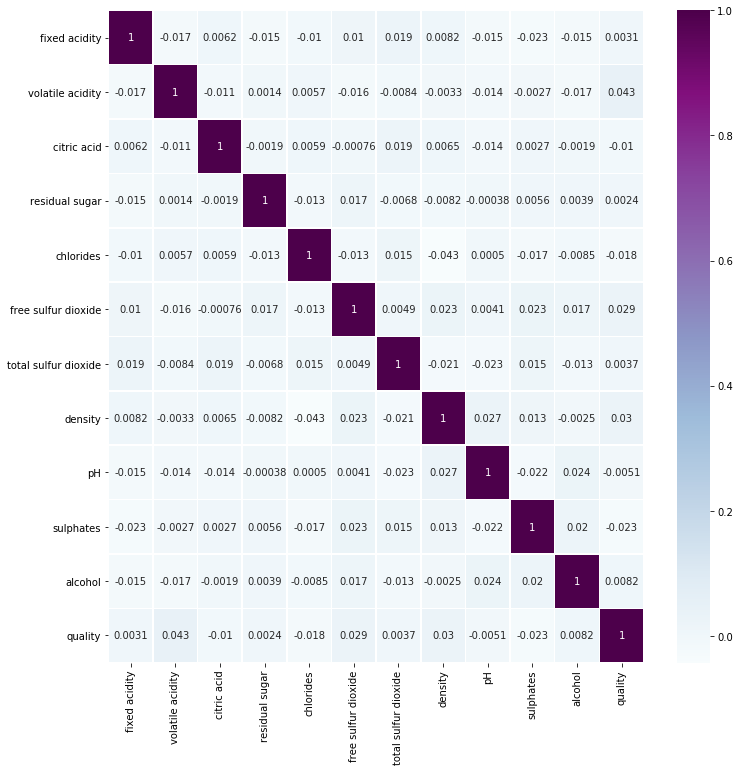

In [388]:
plt.figure(figsize=(12,12))
sns.heatmap(data.corr(),cmap="BuPu", annot=True, linewidths=0.5)

In [389]:
data['quality'] = pd.cut(data['quality'], bins = [1,6,10], labels = [0,1]).astype(int)
data.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,8.7,0.300,0.49,6.50,0.051,50.0,125.0,0.99240,3.18,0.42,10.9,0
1,6.8,0.270,0.28,31.60,0.021,43.5,191.0,0.99226,3.28,0.47,11.0,0
2,6.5,0.170,0.49,11.75,0.118,41.0,195.0,0.99293,3.22,0.43,10.1,0
3,8.3,0.190,0.32,2.50,0.045,18.0,163.0,0.99330,3.04,0.52,10.4,1
4,7.1,0.555,0.40,4.00,0.050,16.0,154.0,0.99590,3.20,0.62,9.3,0
5,6.1,0.240,0.21,7.10,0.045,17.0,116.0,0.99390,3.17,0.47,11.7,0
6,6.3,0.300,0.28,13.70,0.051,28.0,30.0,0.99660,3.17,0.57,11.4,1
7,7.2,0.210,0.37,12.90,0.041,29.0,133.0,0.99590,3.25,0.34,12.8,0
8,6.6,0.190,0.49,7.40,0.047,31.0,92.0,0.98958,3.15,0.37,10.4,1
9,7.8,0.280,0.30,13.90,0.034,44.0,128.0,0.99400,3.01,0.42,10.8,1


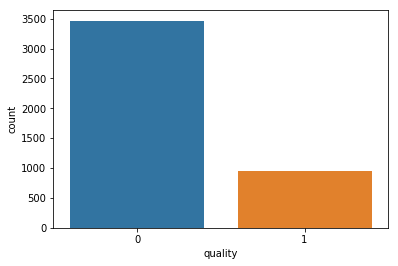

In [390]:
sns.countplot(x='quality', data=data)
plt.show()

In [391]:
y=data.quality.values
x=data.drop(["quality"],axis=1)

In [392]:
x=((x-np.min(x)) / (np.max(x)-np.min(x)))

In [393]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [394]:
model = RegularizedLogisticRegression(lr=0.001, num_iter=10000,reg=100)
model.fit(x_train,y_train)
preds = model.predict(x_test,0.5)
(preds == y_test).mean()

0.7891156462585034

## ONE VS ALL

In [395]:
data=pd.read_csv("wine-quality/data.csv",sep=';')
data.head()
data = data.apply(np.random.permutation)
data.loc[(data.quality >=3) & (data.quality <= 5), 'quality'] = 0
data.loc[(data.quality >=6) & (data.quality <= 7), 'quality'] = 1
data.loc[(data.quality >=8) & (data.quality <= 9), 'quality'] = 2 

# data['quality'] = pd.cut(data['quality'], bins = [1,6,10], labels = [0,1]).astype(int)
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,5.9,0.37,0.49,19.35,0.031,47.0,121.0,0.99047,3.05,0.50,10.2,1
1,7.3,0.23,0.36,12.10,0.056,42.0,164.0,0.99084,3.39,0.49,9.5,2
2,7.7,0.30,0.31,1.80,0.041,58.0,117.0,0.99397,2.97,0.45,11.2,1
3,6.7,0.19,0.46,2.50,0.046,13.0,189.0,0.99192,3.15,0.37,10.2,1
4,7.1,0.29,0.33,1.40,0.050,24.0,68.0,0.99462,3.01,0.40,10.2,1


In [396]:
qualities = [0,1,2]
#Number of examples
m = data.shape[0]
#Features
n = 11

k = 3

X = np.ones((m,n + 1))
y = np.array((m,1))
X[:,1] = data['fixed acidity'].values
X[:,2] = data['volatile acidity'].values
X[:,3] = data['citric acid'].values
X[:,4] = data['residual sugar'].values
X[:,5] = data['chlorides'].values
X[:,6] = data['free sulfur dioxide'].values
X[:,7] = data['total sulfur dioxide'].values
X[:,8] = data['density'].values
X[:,9] = data['pH'].values
X[:,10] = data['sulphates'].values
X[:,11] = data['alcohol'].values

#Labels
y = data['quality'].values

for j in range(n):
    X[:, j] = (X[:, j] - X[:,j].mean())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 11)

In [397]:
#Logistic Regression

def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

#Regularized cost function
def regCostFunction(theta, X, y, _lambda = 0.1):
    m = len(y)
    h = sigmoid(X.dot(theta))
    reg = (_lambda/(2 * m)) * np.sum(theta**2)

    return (1 / m) * (-y.T.dot(np.log(h)) - (1 - y).T.dot(np.log(1 - h))) + reg

#Regularized gradient function
def regGradient(theta, X, y, _lambda = 0.1):
    m, n = X.shape
    theta = theta.reshape((n, 1))
    y = y.reshape((m, 1))
    h = sigmoid(X.dot(theta))
    reg = _lambda * theta /m

    return ((1 / m) * X.T.dot(h - y)) + reg

#Optimal theta 
def logisticRegression(X, y, theta):
    result = op.minimize(fun = regCostFunction, x0 = theta, args = (X, y),
                         method = 'TNC', jac = regGradient)
    
    return result.x

In [398]:
all_theta = np.zeros((k, n + 1))

#One vs all
i = 0
for ql in qualities:
    #set the labels in 0 and 1
    tmp_y = np.array(y_train == ql, dtype = int)
    optTheta = logisticRegression(X_train, tmp_y, np.zeros((n + 1,1)))
    all_theta[i] = optTheta
    i += 1

In [399]:
P = sigmoid(X_test.dot(all_theta.T)) #probability for each flower
p = [qualities[np.argmax(P[i, :])] for i in range(X_test.shape[0])]
print("Test Accuracy ", accuracy_score(y_test, p) * 100 , '%')

Test Accuracy  64.62585034013605 %
